In [3]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import welch, butter, lfilter
import noisereduce as nr
from pydub import AudioSegment
from pydub.effects import normalize

In [64]:
file_path = r'data/db0/fan/id_00/abnormal/00000010.wav'

In [65]:
audio, sample_rate = librosa.load(file_path, mono=True)

In [66]:
audio

array([-0.01936482, -0.02195735, -0.01896692, ..., -0.01299339,
       -0.01418912, -0.00890271], dtype=float32)

In [67]:
from IPython.display import Audio

In [68]:
Audio(data=audio, rate=sample_rate)

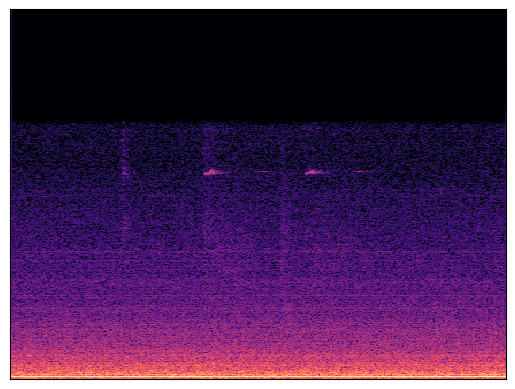

In [69]:
D = librosa.stft(audio)
  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db)

In [70]:
den = librosa.core.istft(D)
Audio(den, rate=sample_rate)

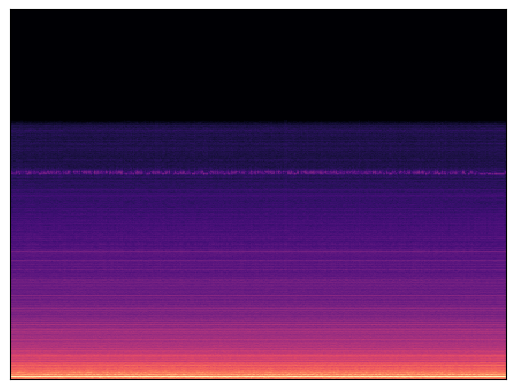

In [71]:
nlm = librosa.decompose.nn_filter(np.abs(D),aggregate=np.mean, axis=1)
S_db = librosa.amplitude_to_db(np.abs(nlm), ref=np.max)
librosa.display.specshow(S_db)

In [72]:
den = librosa.core.istft(nlm)
Audio(den, rate=sample_rate)

In [9]:
# Функция для удаления эха
def remove_echo(audio, sample_rate):
  # Преобразование в формат pydub
  audio_segment = AudioSegment(
      audio.tobytes(),
      frame_rate=sample_rate,
      sample_width=audio.dtype.itemsize,
      channels=1
  )
  # Нормализация и удаление эха
  audio_segment = normalize(audio_segment)
  return np.array(audio_segment.get_array_of_samples())

In [73]:
Audio(remove_echo(audio, sample_rate), rate=sample_rate)

In [11]:
# Функции для удаления шумов (если понадобятся)
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

In [74]:
def reduce_noise(audio, sample_rate):
  return nr.reduce_noise(y=audio, sr=sample_rate) # новая функция, мб заменить

In [75]:
Audio(reduce_noise(audio, sample_rate), rate=sample_rate)

In [17]:
def nn_filter(mel):
    return librosa.decompose.nn_filter(mel, axis=1)

In [33]:
res = librosa.decompose.nn_filter(librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40), axis=1, aggregate=np.median)
res

array([[4.7052640e-02, 8.9494795e-02, 1.2647140e-01, ..., 1.0884759e-01,
        5.9458517e-02, 5.2869000e-02],
       [3.1982169e-02, 5.4115400e-02, 6.0745794e-02, ..., 5.9189714e-02,
        4.4984683e-02, 4.1573144e-02],
       [2.3050576e-02, 3.2397777e-02, 2.6110400e-02, ..., 4.5528747e-02,
        4.1858613e-02, 3.9697960e-02],
       ...,
       [1.0132139e-15, 1.0478563e-15, 1.2389437e-15, ..., 9.9234187e-16,
        9.3748294e-16, 1.0493995e-15],
       [4.8097171e-17, 6.5140248e-17, 8.0761402e-17, ..., 7.9562003e-17,
        5.8132612e-17, 5.2117679e-17],
       [1.4507663e-16, 2.0556837e-16, 2.3105428e-16, ..., 2.5034779e-16,
        2.0067267e-16, 1.7572708e-16]], dtype=float32)

In [34]:
a = librosa.feature.inverse.mel_to_audio(res)

<Axes: >

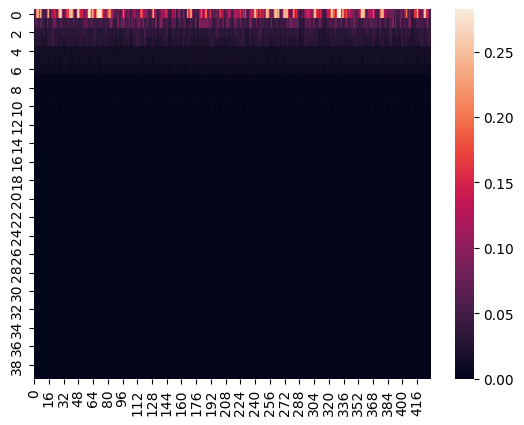

In [36]:
import seaborn as sns


sns.heatmap(res)

<Axes: >

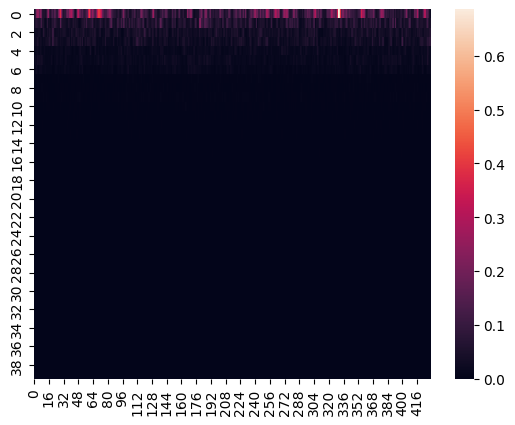

In [37]:

sns.heatmap(librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40))

In [35]:
Audio(a, rate=sample_rate)

In [ ]:
# Функция для извлечения признаков
def extract_features(file_path):
  # Загрузка файла
  audio, sample_rate = librosa.load(file_path)

  # Эхоподавление
  # audio = remove_echo(audio, sample_rate).astype(np.float32) # а надо ли???
  # Удаление шума
  audio = reduce_noise(audio=audio, sample_rate=sample_rate)

  # D = librosa.stft(audio)  # STFT of y
  # S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  # librosa.display.specshow(S_db)
  # plt.colorbar()

  # Извлечение мелспектрограммы
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40, fmax=8000)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

  # librosa.display.specshow(mel_spectrogram_db)
  
  mel_features = np.mean(mel_spectrogram_db.T, axis=0)
  # Извлечение спектра Уэльса (PSD)
  freqs, psd = welch(audio, fs=sample_rate)
  psd_features = np.mean(psd)
  # Объединение признаков в один вектор
  combined_features = np.hstack((mel_features, psd_features))

  return combined_features

In [ ]:
extract_features(file_path).shape

(41,)

In [ ]:
# Списки для хранения признаков и меток
features = []
labels = []

In [ ]:
for root, dirs, files in os.walk(data_dir):
  for file in files:
    if file.endswith('.wav'):
      file_path = os.path.join(root, file)
      feature = extract_features(file_path)
      if feature is not None:
        features.append(feature)
        labels.append(1 if 'abnormal' in file else 0)

In [ ]:
# Нормализация данных
X = np.array(features)
y = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import os
import pandas as pd

root_dir = 'data'

data = []

for db in os.listdir(root_dir):
  db_path = os.path.join(root_dir, db)
  if os.path.isdir(db_path):
    for name in os.listdir(db_path):
      name_path = os.path.join(db_path, name)
      if os.path.isdir(name_path):
        for id_ in os.listdir(name_path):
          id_path = os.path.join(name_path, id_)
          if os.path.isdir(id_path):
            for norm in os.listdir(id_path):
              norm_path = os.path.join(id_path, norm)
              if os.path.isdir(norm_path):
                for fn in os.listdir(norm_path):
                  if fn.endswith('.wav'):
                    is_norm_value = 0 if norm == 'abnormal' else 1
                    data.append({
                      'db': db,
                      'name': name,
                      'id': id_,
                      'is_norm': is_norm_value,
                      'file_name': fn
                    })

df = pd.DataFrame(data)
df